# *Sign Language Detection*

In [1]:
# Import all required packages
from torch.utils.data import Dataset
from torch.autograd import Variable
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
import torch
from typing import List
import csv

class SignLanguageMNIST(Dataset):
    """Sign Language classification dataset for A-Y without J (J and Z require movement)
    Each sample is 1 x 1 x 28 x 28, and each label is a scalar.
    """

    @staticmethod
    def get_label_mapping():
        """
        Return the label mapping which contains a list 0-24 without 9
        """
        mapping = list(range(25))
        mapping.pop(9)
        return mapping

    @staticmethod
    def read_label_samples_from_csv(path: str):
        """
        Args:
            path: Path to dataset (.csv file) 
        First column in CSV is the label and remaining 28x28 values
        are image pixel values.
        Returns:
            labels: labels got from the mapping function
            samples: all the samples in the csv file 
        """
        mapping = SignLanguageMNIST.get_label_mapping()
        labels, samples = [], []
        with open(path) as f:
            _ = next(f)  # skip header
            for line in csv.reader(f):
                label = int(line[0])
                labels.append(mapping.index(label))
                samples.append(list(map(int, line[1:])))
        return labels, samples

    def __init__(self,
            path: str="sign_mnist_train.csv",
            mean: List[float]=[0.485],
            std: List[float]=[0.229]):
        """
        Args:
            path: Path to dataset (.csv file) 
            mean: Mean of the dataset, has value set default
            std: Standard Deviation of the dataset, has value set default`
        """
        labels, samples = SignLanguageMNIST.read_label_samples_from_csv(path)
        self._samples = np.array(samples, dtype=np.uint8).reshape((-1, 28, 28, 1))
        self._labels = np.array(labels, dtype=np.uint8).reshape((-1, 1))

        self._mean = mean
        self._std = std

    def __len__(self):
        return len(self._labels)

    def __getitem__(self, idx):
        """
        Args:
            idx: index of the image 
        Apply transforms to convert to PILImage, apply crop,
        convert to tensor and normalize the tensor.
        Returns:
            image,label: transformes image and its respective label 
        """
        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomResizedCrop(28, scale=(0.8, 1.2)),
            transforms.ToTensor(),
            transforms.Normalize(mean=self._mean, std=self._std)])

        return {
            'image': transform(self._samples[idx]).float(),
            'label': torch.from_numpy(self._labels[idx]).float()
        }
    
    

C:\Users\Ayush\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Ayush\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\Ayush\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Importing Test & Train Data

In [2]:
def get_train_test_loaders(batch_size=32):
    """
    Args:
        batch_size: optional argument, default is 32
    Creates training and testing dataloaders.
        """
    trainset = SignLanguageMNIST('sign_mnist_train.csv')
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

    testset = SignLanguageMNIST('sign_mnist_test.csv')
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
    return trainloader, testloader

In [3]:
if __name__ == '__main__':
    loader, _ = get_train_test_loaders(2)
    print(next(iter(loader)))

{'image': tensor([[[[ 0.5536,  0.6563,  0.7419,  ...,  1.0331,  0.9988,  0.9817],
          [ 0.5536,  0.6563,  0.7419,  ...,  1.0502,  1.0331,  0.9988],
          [ 0.5536,  0.6563,  0.7591,  ...,  1.0673,  1.0502,  1.0159],
          ...,
          [ 0.5878,  0.7248,  0.8447,  ...,  1.2899,  1.2557,  1.2385],
          [ 0.5707,  0.7077,  0.8447,  ...,  1.2899,  1.2728,  1.2385],
          [ 0.5536,  0.6906,  0.8276,  ...,  1.2728,  1.2385,  1.2214]]],


        [[[ 1.1872,  1.2214,  1.2385,  ...,  1.2214,  1.2214,  1.2043],
          [ 1.2214,  1.2214,  1.2557,  ...,  1.2214,  1.2385,  1.2214],
          [ 1.2385,  1.2557,  1.2899,  ...,  1.2385,  1.2385,  1.2214],
          ...,
          [ 1.2899,  1.4783,  1.5468,  ...,  1.5297,  1.5125,  1.5297],
          [-0.6623, -0.0287,  1.2385,  ...,  1.5297,  1.5297,  1.5125],
          [-0.9192, -0.8507,  1.0331,  ...,  1.5297,  1.5468,  1.5125]]]]), 'label': tensor([[12.],
        [12.]])}


## Modelling

In [4]:
"""CNN based Model architecture"""
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 6, 3)
        self.conv3 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 48)
        self.fc3 = nn.Linear(48, 24)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Training

In [5]:
"""Train model for 20 epochs, with a learning rate of 0.01, 0.9 momentum, 
SGD optimizer and save the trained model"""


import torch.optim as optim
import torch.nn.functional as F

def main():
    net = Net().float()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

    trainloader, _ = get_train_test_loaders()
    for epoch in range(20):  
        train(net, criterion, optimizer, trainloader, epoch)
    torch.save(net.state_dict(), "checkpoint.pth")


def train(net, criterion, optimizer, trainloader, epoch):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs = Variable(data['image'].float())
        labels = Variable(data['label'].long())
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels[:, 0])
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 0:
            print('[%d, %5d] loss: %.6f' % (epoch, i, running_loss / (i + 1)))


if __name__ == '__main__':
    main()

[0,     0] loss: 3.175570
[0,   100] loss: 3.180495
[0,   200] loss: 3.175907
[0,   300] loss: 3.097948
[0,   400] loss: 2.855439
[0,   500] loss: 2.603433
[0,   600] loss: 2.358903
[0,   700] loss: 2.142240
[0,   800] loss: 1.952206
[1,     0] loss: 0.692393
[1,   100] loss: 0.451821
[1,   200] loss: 0.397930
[1,   300] loss: 0.371854
[1,   400] loss: 0.357372
[1,   500] loss: 0.332916
[1,   600] loss: 0.311287
[1,   700] loss: 0.296977
[1,   800] loss: 0.279077
[2,     0] loss: 0.223799
[2,   100] loss: 0.154910
[2,   200] loss: 0.146371
[2,   300] loss: 0.139851
[2,   400] loss: 0.132055
[2,   500] loss: 0.125485
[2,   600] loss: 0.127426
[2,   700] loss: 0.126098
[2,   800] loss: 0.125245
[3,     0] loss: 0.123351
[3,   100] loss: 0.087502
[3,   200] loss: 0.093004
[3,   300] loss: 0.096029
[3,   400] loss: 0.092315
[3,   500] loss: 0.092013
[3,   600] loss: 0.091829
[3,   700] loss: 0.091092
[3,   800] loss: 0.087449
[4,     0] loss: 0.053296
[4,   100] loss: 0.081925
[4,   200] l

In [6]:
from torch.utils.data import Dataset
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import numpy as np


def evaluate(outputs: Variable, labels: Variable) -> float:
    """Evaluate model outputs """
    Y = labels.numpy()
    Yhat = np.argmax(outputs, axis=1)
    return float(np.sum(Yhat == Y))


def batch_evaluate(
        net: Net,
        dataloader: torch.utils.data.DataLoader) -> float:
    """Evaluate model in batches, if dataset is too large."""
    score = n = 0.0
    for batch in dataloader:
        n += len(batch['image'])
        outputs = net(batch['image'])
        if isinstance(outputs, torch.Tensor):
            outputs = outputs.detach().numpy()
        score += evaluate(outputs, batch['label'][:, 0])
    return score / n


def validate():
    trainloader, testloader = get_train_test_loaders()
    net = Net().float().eval()

    pretrained_model = torch.load("checkpoint.pth")
    net.load_state_dict(pretrained_model)

    print('=' * 10, 'PyTorch', '=' * 10)
    train_acc = batch_evaluate(net, trainloader) * 100.
    print('Training accuracy: %.1f' % train_acc)
    test_acc = batch_evaluate(net, testloader) * 100.
    print('Validation accuracy: %.1f' % test_acc)

    trainloader, testloader = get_train_test_loaders(1)


if __name__ == '__main__':
    validate()

========== PyTorch ==========
Training accuracy: 99.2
Validation accuracy: 96.0


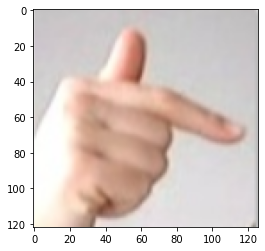

In [50]:
"""Testing on custom individual data"""

import cv2
import matplotlib.pyplot as plt
from PIL import Image

index_to_letter = list('ABCDEFGHIKLMNOPQRSTUVWXY')
bgr_img = cv2.imread('D:/test2/VI.png')
img = cv2.cvtColor(bgr_img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

## Testing

In [51]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
pixels = cv2.resize(gray,(28,28))
pixels = pixels-np.min(pixels)/(np.max(pixels)-np.min(pixels))
data = pixels.reshape(1, 1, 28, 28).astype(np.float32)

model = Net().float().eval()
pretrained_model = torch.load('checkpoint.pth')
model.load_state_dict(pretrained_model)
model.eval()
x = torch.FloatTensor(data)
y = model(Variable(x))
pred = torch.argmax(y).cpu().numpy()
print('The letter signed in the image is:')
print(index_to_letter[int(pred)])

The letter signed in the image is:
T
